# Classifier using LSTM layers

## 1. Importing Libraries

In [4]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Data Preprocessing

### 2.1. Loading the data

In [5]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [6]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

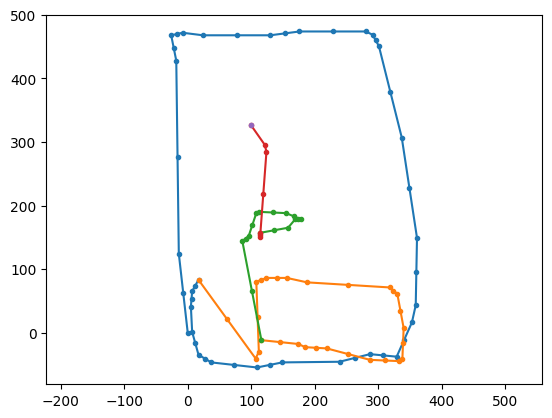

In [7]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [8]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    camera_labels = np.ones(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2
    calculator_labels = np.zeros(calculator_drawings.shape[0])

    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [10]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

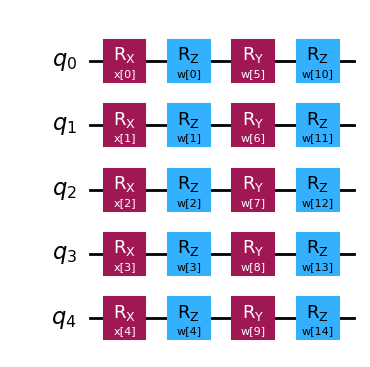

In [12]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    for i in range(n):
        circuit.rz(weights[i], i)

    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    return circuit

def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [14]:
checkpoint_filepath = 'models/2edition_quantum_lstm/best_model_weights_3classes_withoutCNOTs.pth'

In [16]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(50):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
 
        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 192/192 [09:25<00:00,  2.94s/it]


Epoch 1, Accuracy: 0.5306803385416666, Loss: 1.033155893906951, Validation Accuracy: 0.6236979166666666, Validation Loss: 0.9690260887145996


100%|██████████| 192/192 [09:37<00:00,  3.01s/it]


Epoch 2, Accuracy: 0.6202799479166666, Loss: 0.9319781878342231, Validation Accuracy: 0.6116536458333334, Validation Loss: 0.9291794300079346


100%|██████████| 192/192 [09:47<00:00,  3.06s/it]


Epoch 3, Accuracy: 0.6324869791666666, Loss: 0.8612903989851475, Validation Accuracy: 0.6396484375, Validation Loss: 0.8316090106964111


100%|██████████| 192/192 [09:42<00:00,  3.03s/it]


Epoch 4, Accuracy: 0.637939453125, Loss: 0.8063063186903795, Validation Accuracy: 0.6402994791666666, Validation Loss: 0.7950459718704224


100%|██████████| 192/192 [09:37<00:00,  3.01s/it]


Epoch 5, Accuracy: 0.639892578125, Loss: 0.766879758797586, Validation Accuracy: 0.6471354166666666, Validation Loss: 0.7692641019821167


100%|██████████| 192/192 [09:27<00:00,  2.96s/it]


Epoch 6, Accuracy: 0.6420084635416666, Loss: 0.7413439573720098, Validation Accuracy: 0.6458333333333334, Validation Loss: 0.7422925233840942


100%|██████████| 192/192 [09:21<00:00,  2.92s/it]


Epoch 7, Accuracy: 0.6470540364583334, Loss: 0.7127249045297503, Validation Accuracy: 0.6487630208333334, Validation Loss: 0.7162631750106812


100%|██████████| 192/192 [08:56<00:00,  2.79s/it]


Epoch 8, Accuracy: 0.6541341145833334, Loss: 0.6886977994193634, Validation Accuracy: 0.6572265625, Validation Loss: 0.7057523727416992


100%|██████████| 192/192 [08:46<00:00,  2.74s/it]


Epoch 9, Accuracy: 0.6609700520833334, Loss: 0.6722538191825151, Validation Accuracy: 0.6389973958333334, Validation Loss: 0.7057611346244812


100%|██████████| 192/192 [08:40<00:00,  2.71s/it]


Epoch 10, Accuracy: 0.6707356770833334, Loss: 0.6585624630873402, Validation Accuracy: 0.6803385416666666, Validation Loss: 0.6996330618858337


100%|██████████| 192/192 [08:37<00:00,  2.70s/it]


Epoch 11, Accuracy: 0.6845703125, Loss: 0.6389897912740707, Validation Accuracy: 0.6891276041666666, Validation Loss: 0.6863422393798828


100%|██████████| 192/192 [08:35<00:00,  2.68s/it]


Epoch 12, Accuracy: 0.8087565104166666, Loss: 0.6162565789806346, Validation Accuracy: 0.8919270833333334, Validation Loss: 0.6266372799873352


100%|██████████| 192/192 [08:44<00:00,  2.73s/it]


Epoch 13, Accuracy: 0.9169921875, Loss: 0.5808729416069885, Validation Accuracy: 0.9065755208333334, Validation Loss: 0.5874497890472412


100%|██████████| 192/192 [08:44<00:00,  2.73s/it]


Epoch 14, Accuracy: 0.928955078125, Loss: 0.5390571501726905, Validation Accuracy: 0.8971354166666666, Validation Loss: 0.5673359632492065


100%|██████████| 192/192 [08:43<00:00,  2.73s/it]


Epoch 15, Accuracy: 0.932861328125, Loss: 0.4997442384871344, Validation Accuracy: 0.91796875, Validation Loss: 0.5028010010719299


100%|██████████| 192/192 [08:57<00:00,  2.80s/it]


Epoch 16, Accuracy: 0.9397786458333334, Loss: 0.46344078130399186, Validation Accuracy: 0.9176432291666666, Validation Loss: 0.47606348991394043


100%|██████████| 192/192 [08:42<00:00,  2.72s/it]


Epoch 17, Accuracy: 0.9432779947916666, Loss: 0.43685435395066935, Validation Accuracy: 0.9153645833333334, Validation Loss: 0.4619675874710083


100%|██████████| 192/192 [08:40<00:00,  2.71s/it]


Epoch 18, Accuracy: 0.9404296875, Loss: 0.41903972982739407, Validation Accuracy: 0.9114583333333334, Validation Loss: 0.44750043749809265


100%|██████████| 192/192 [08:34<00:00,  2.68s/it]


Epoch 19, Accuracy: 0.944091796875, Loss: 0.39476899957905215, Validation Accuracy: 0.919921875, Validation Loss: 0.4163115918636322


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 20, Accuracy: 0.94580078125, Loss: 0.375880668250223, Validation Accuracy: 0.9202473958333334, Validation Loss: 0.40281689167022705


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 21, Accuracy: 0.9493001302083334, Loss: 0.3530133410046498, Validation Accuracy: 0.9235026041666666, Validation Loss: 0.38388317823410034


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 22, Accuracy: 0.9486490885416666, Loss: 0.34449725272133946, Validation Accuracy: 0.9241536458333334, Validation Loss: 0.36501678824424744


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 23, Accuracy: 0.952392578125, Loss: 0.32136331335641444, Validation Accuracy: 0.9267578125, Validation Loss: 0.36349815130233765


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 24, Accuracy: 0.9561360677083334, Loss: 0.3069059345095108, Validation Accuracy: 0.9231770833333334, Validation Loss: 0.3478092551231384


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 25, Accuracy: 0.9573567708333334, Loss: 0.29079216516887146, Validation Accuracy: 0.9244791666666666, Validation Loss: 0.33888792991638184


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 26, Accuracy: 0.963134765625, Loss: 0.27435947908088565, Validation Accuracy: 0.9235026041666666, Validation Loss: 0.32973402738571167


100%|██████████| 192/192 [08:29<00:00,  2.66s/it]


Epoch 27, Accuracy: 0.963623046875, Loss: 0.26328566825638217, Validation Accuracy: 0.9280598958333334, Validation Loss: 0.32027989625930786


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 28, Accuracy: 0.960693359375, Loss: 0.2575705316849053, Validation Accuracy: 0.92578125, Validation Loss: 0.3142077326774597


100%|██████████| 192/192 [08:26<00:00,  2.64s/it]


Epoch 29, Accuracy: 0.9654134114583334, Loss: 0.24151121095443764, Validation Accuracy: 0.9163411458333334, Validation Loss: 0.3273282051086426


100%|██████████| 192/192 [08:24<00:00,  2.63s/it]


Epoch 30, Accuracy: 0.9618326822916666, Loss: 0.23965046911810836, Validation Accuracy: 0.9274088541666666, Validation Loss: 0.3035707473754883


100%|██████████| 192/192 [08:27<00:00,  2.65s/it]


Epoch 31, Accuracy: 0.9606119791666666, Loss: 0.23522159201093018, Validation Accuracy: 0.92578125, Validation Loss: 0.2993254065513611


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 32, Accuracy: 0.96875, Loss: 0.21161106686728695, Validation Accuracy: 0.9251302083333334, Validation Loss: 0.306902140378952


100%|██████████| 192/192 [08:27<00:00,  2.64s/it]


Epoch 33, Accuracy: 0.968017578125, Loss: 0.2083417106575022, Validation Accuracy: 0.9267578125, Validation Loss: 0.28879010677337646


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 34, Accuracy: 0.9701334635416666, Loss: 0.19782257809614143, Validation Accuracy: 0.9222005208333334, Validation Loss: 0.2935883104801178


100%|██████████| 192/192 [08:26<00:00,  2.64s/it]


Epoch 35, Accuracy: 0.9707845052083334, Loss: 0.18782060725303987, Validation Accuracy: 0.9189453125, Validation Loss: 0.2995379567146301


100%|██████████| 192/192 [08:33<00:00,  2.68s/it]


Epoch 36, Accuracy: 0.9742838541666666, Loss: 0.17780064915617308, Validation Accuracy: 0.9212239583333334, Validation Loss: 0.28575894236564636


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 37, Accuracy: 0.9781087239583334, Loss: 0.1632947886052231, Validation Accuracy: 0.9202473958333334, Validation Loss: 0.2910558581352234


100%|██████████| 192/192 [08:31<00:00,  2.66s/it]


Epoch 38, Accuracy: 0.9728190104166666, Loss: 0.16975363068437824, Validation Accuracy: 0.9153645833333334, Validation Loss: 0.3056003153324127


100%|██████████| 192/192 [08:30<00:00,  2.66s/it]


Epoch 39, Accuracy: 0.971435546875, Loss: 0.16889177286066115, Validation Accuracy: 0.9189453125, Validation Loss: 0.28316912055015564


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 40, Accuracy: 0.9765625, Loss: 0.15328883519396186, Validation Accuracy: 0.9212239583333334, Validation Loss: 0.27616286277770996


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 41, Accuracy: 0.976806640625, Loss: 0.14720551921830824, Validation Accuracy: 0.9205729166666666, Validation Loss: 0.2766880691051483


100%|██████████| 192/192 [08:26<00:00,  2.64s/it]


Epoch 42, Accuracy: 0.9767252604166666, Loss: 0.1448937391008561, Validation Accuracy: 0.9215494791666666, Validation Loss: 0.2721528708934784


100%|██████████| 192/192 [08:29<00:00,  2.65s/it]


Epoch 43, Accuracy: 0.980224609375, Loss: 0.13415947300381958, Validation Accuracy: 0.92578125, Validation Loss: 0.25959640741348267


100%|██████████| 192/192 [08:31<00:00,  2.67s/it]


Epoch 44, Accuracy: 0.9825846354166666, Loss: 0.1242751928512007, Validation Accuracy: 0.9267578125, Validation Loss: 0.2620987892150879


100%|██████████| 192/192 [08:27<00:00,  2.64s/it]


Epoch 45, Accuracy: 0.9832356770833334, Loss: 0.11937936333318551, Validation Accuracy: 0.9270833333333334, Validation Loss: 0.26764971017837524


100%|██████████| 192/192 [08:24<00:00,  2.63s/it]


Epoch 46, Accuracy: 0.97998046875, Loss: 0.12342426627098273, Validation Accuracy: 0.9251302083333334, Validation Loss: 0.2672140300273895


100%|██████████| 192/192 [08:24<00:00,  2.63s/it]


Epoch 47, Accuracy: 0.9793294270833334, Loss: 0.1216721428014959, Validation Accuracy: 0.921875, Validation Loss: 0.2717379629611969


100%|██████████| 192/192 [08:25<00:00,  2.63s/it]


Epoch 48, Accuracy: 0.9833170572916666, Loss: 0.11023792793275788, Validation Accuracy: 0.919921875, Validation Loss: 0.27972155809402466


100%|██████████| 192/192 [08:27<00:00,  2.64s/it]


Epoch 49, Accuracy: 0.98291015625, Loss: 0.10742551610261823, Validation Accuracy: 0.9195963541666666, Validation Loss: 0.2824348211288452


100%|██████████| 192/192 [08:28<00:00,  2.65s/it]


Epoch 50, Accuracy: 0.98291015625, Loss: 0.10554311614638816, Validation Accuracy: 0.9244791666666666, Validation Loss: 0.27384257316589355


## 5. Model Evaluation

In [22]:
val_loss_list_converted = []
for loss in val_loss_list:
    val_loss_list_converted.append(loss.item())

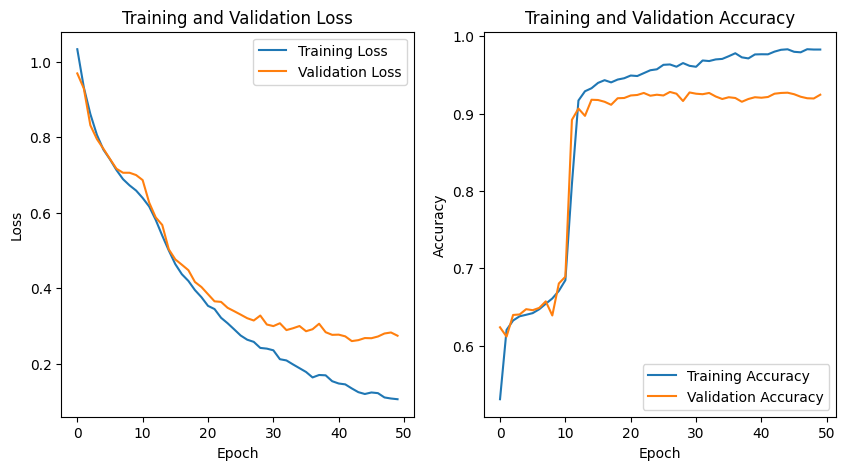

In [24]:
def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list_converted, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [ ]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [ ]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])